# DCGAN (Deep Convolutional Generative Adversarial Network)

- Published in 2015 by Radford et al.
- Similar to the original GAN, but uses Deep Convolutional Networks instead of fully-connected
- This implies that the DCGAN is more suitable to work with images and videos
- The generator receive as input a random noise and returns a **fake** image
- The discriminator receives as input real and fake images and returns a value between **0** and **1** to indicates how much true is the image
- Uses **binary cross-entropy** as loss function
- The generator don't see the real images, just learns by the discriminator feedback

# Importing Libraries

In [39]:
import numpy      as np
import tensorflow as tf

from tensorflow import keras

In [40]:
import matplotlib.pyplot as plt
import matplotlib        as mpl

## Versions

In [41]:
print(f"Numpy: {np.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
print(f"Matplotlib: {mpl.__version__}")

Numpy: 1.22.4
Tensorflow: 2.12.0
Keras: 2.12.0
Matplotlib: 3.7.1


# Data Preprocessing

In [42]:
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

In [43]:
X_train.shape

(60000, 28, 28)

60000 images 28x28

In [44]:
y_train.shape

(60000,)

60000 labels

## Visualizating

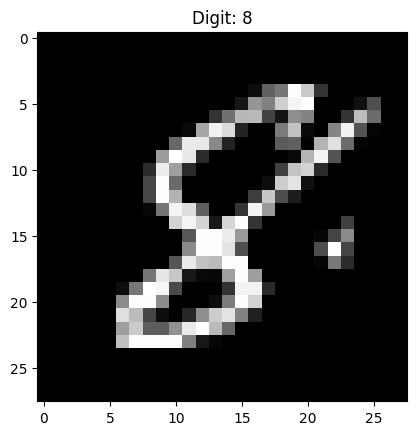

In [45]:
i = np.random.randint(0, 60000)

plt.imshow(X_train[i], cmap="gray")

plt.title(f"Digit: {y_train[i]}")

plt.show()

The original images have **3** channels of colors, so let's take only **1**

## Reshape

In [46]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")

## Normalize

The `max` and `min` value for a pixel

In [47]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

Now we need to **normalize** the values. When using GAN's it's usual normalize in [-1, 1] scale

In [48]:
medium_value = (255 - 0) / 2

medium_value

127.5

In [49]:
X_train = (X_train - medium_value) / medium_value

So now, the `min` and `max` are

In [50]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

## Batches

In [51]:
BUFFER_SIZE = 60000
BATCH_SIZE  = 256

In [52]:
BUFFER_SIZE / BATCH_SIZE

234.375

This mean we have **234 batches** and each batch with **256 images**.

## Creating Dataset

In [53]:
type(X_train)

numpy.ndarray

In [54]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [55]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

# Creating **Generator**

In [62]:
def generator():
  net = keras.Sequential(name="Generator")

  net.add(keras.layers.Dense(units=7*7*BATCH_SIZE, use_bias=False, input_shape=(100,)))
  net.add(keras.layers.BatchNormalization())
  net.add(keras.layers.LeakyReLU())

  net.add(keras.layers.Reshape((7, 7, BATCH_SIZE)))

  # 7 x 7 x 128
  net.add(keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), padding="same", use_bias=False))
  net.add(keras.layers.BatchNormalization())
  net.add(keras.layers.LeakyReLU())

  # 14 x 14 x 64
  net.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), padding="same", use_bias=False, strides=(2, 2)))
  net.add(keras.layers.BatchNormalization())
  net.add(keras.layers.LeakyReLU())

  # 28 x 28 x 1
  net.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=(5, 5), padding="same", use_bias=False, strides=(2, 2), activation="tanh"))

  net.summary()

  return net

In [66]:
gen_net = generator()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_12 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 7, 128)        51

In [67]:
gen_net.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_4_input')>

In [71]:
noise = tf.random.normal([1, 100])

gen_image = gen_net(noise, training=False)

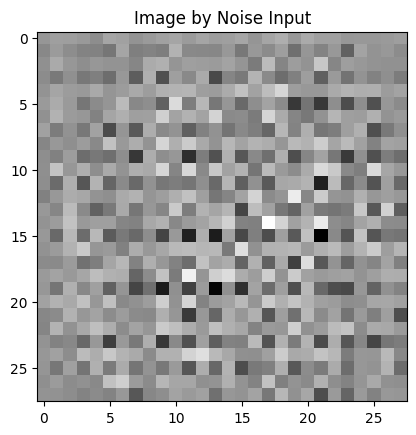

In [75]:
plt.imshow(gen_image[0, :, :, 0], cmap="gray")

plt.title("Image by Noise Input")

plt.show()

# Creating **Discriminator**